In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    mean_squared_error, r2_score
)

# Paths
PROC = Path("../data/processed")

# Load the **model-ready** features we created in Stage 9
# (from src/features.select_model_dataset → prices_with_tech_features_model.csv)
cand = sorted(PROC.glob("prices_with_tech_features_model*.csv"),
              key=lambda p: p.stat().st_mtime, reverse=True)
assert cand, "No model-ready feature file found in ../data/processed/. Run Stage 9 first."
df = pd.read_csv(cand[0], parse_dates=["date"])
df.head()


,date,ret_1d,ret_1d_z,gap_pct,daily_range_pct,ma_ratio_5_20,ret_vol_10,volume_z20,rsi_14,macd,macd_signal
0,2024-09-13 04:00:00+00:00,-0.121196,-0.075690,0.003636,0.009573,-0.012617,1.039324,-0.690057,41.810465,-1.172826,-0.867443
1,2024-09-16 04:00:00+00:00,-2.777533,-1.390166,-0.026787,0.015255,-0.014569,1.298852,1.623123,29.133306,-1.623287,-1.018612
2,2024-09-17 04:00:00+00:00,0.217262,0.091795,-0.002635,0.011071,-0.015533,1.067620,0.165649,30.850433,-1.920395,-1.198968
3,2024-09-18 04:00:00+00:00,1.798988,0.874505,0.003506,0.023427,-0.016014,1.223036,1.492577,43.158671,-1.821615,-1.323498
4,2024-09-19 04:00:00+00:00,3.706556,1.818456,0.019484,0.022677,-0.011100,1.693632,1.888495,59.458334,-1.073952,-1.273588


In [3]:
# Create T+1 classification label (no leakage)
df = df.sort_values("date").reset_index(drop=True)
df["y_up"] = (df["ret_1d"].shift(-1) > 0).astype(int)  # predict next day's direction
df_clf = df.dropna().copy()

# Feature sets (you can add/remove easily)
FEAT_BASE = ["gap_pct","daily_range_pct","ma_ratio_5_20","ret_vol_10","volume_z20","rsi_14","macd","macd_signal"]

X = df_clf[FEAT_BASE]
y = df_clf["y_up"]

# Time-aware holdout (last 20% = test)
cut = int(len(df_clf) * 0.8)
X_tr, X_te = X.iloc[:cut], X.iloc[cut:]
y_tr, y_te = y.iloc[:cut], y.iloc[cut:]
dates_te = df_clf["date"].iloc[cut:]
print("Train rows:", len(X_tr), " Test rows:", len(X_te))


Train rows: 184  Test rows: 47


In [4]:
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_holdout(clf, Xtr, ytr, Xte, yte, name="model"):
    clf.fit(Xtr, ytr)
    pred = clf.predict(Xte)
    proba = clf.predict_proba(Xte)[:,1] if hasattr(clf, "predict_proba") else None

    acc  = accuracy_score(yte, pred)
    prec = precision_score(yte, pred, zero_division=0)
    rec  = recall_score(yte, pred, zero_division=0)
    f1   = f1_score(yte, pred, zero_division=0)
    auc  = roc_auc_score(yte, proba) if proba is not None else np.nan

    return {
        "model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc
    }

candidates = []

# 1) Logistic Regression (scaled)
logit = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, C=1.0, class_weight=None))
])
candidates.append(("logit_base", logit))

# 2) Logistic Regression with mild regularization and class_weight
logit_cw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, C=0.5, class_weight="balanced"))
])
candidates.append(("logit_balanced", logit_cw))

# 3) Random Forest (nonlinear baseline)
rf = Pipeline([
    ("scaler", StandardScaler()),  # harmless here; RF doesn’t need scaling
    ("clf", RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=3, random_state=17))
])
candidates.append(("rf_300_leaf3", rf))

results = []
for name, pipe in candidates:
    res = evaluate_holdout(pipe, X_tr, y_tr, X_te, y_te, name)
    results.append(res)

res_df = pd.DataFrame(results).sort_values("f1", ascending=False)
res_df


,model,accuracy,precision,recall,f1,roc_auc
0,logit_base,0.595745,0.633333,0.703704,0.666667,0.535185
1,logit_balanced,0.574468,0.640000,0.592593,0.615385,0.537037
2,rf_300_leaf3,0.425532,0.500000,0.481481,0.490566,0.468519


Best model: logit_base
              precision    recall  f1-score   support

           0      0.529     0.450     0.486        20
           1      0.633     0.704     0.667        27

    accuracy                          0.596        47
   macro avg      0.581     0.577     0.577        47
weighted avg      0.589     0.596     0.590        47



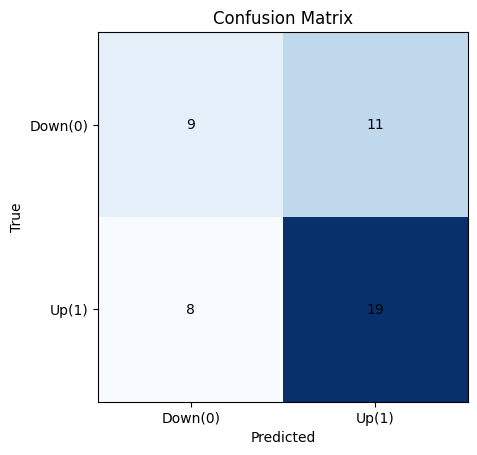

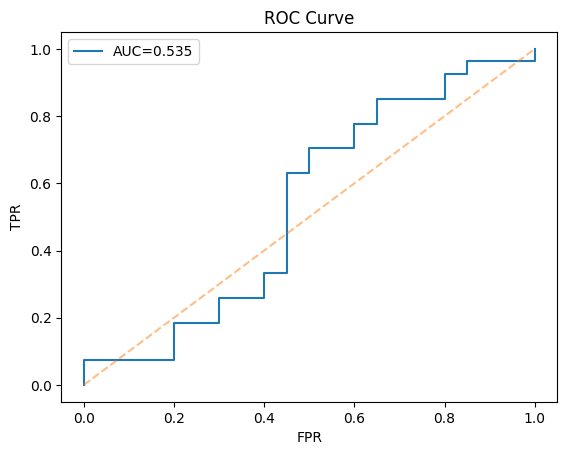

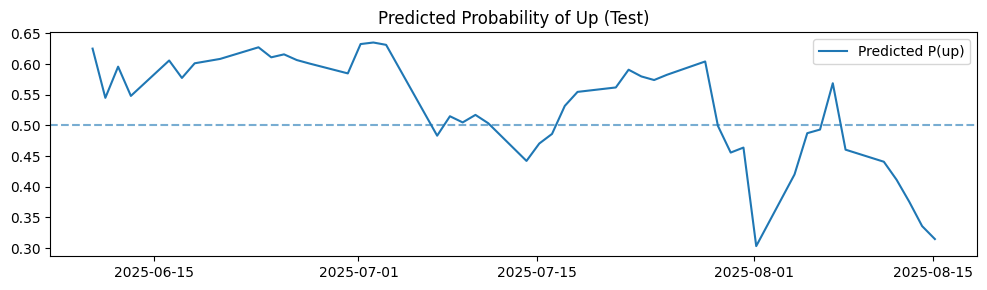

Saved: ../data/processed/stage10_classification_results.csv
Saved: ../data/processed/stage10_logistic_coefficients.csv


In [5]:
best_name = res_df.iloc[0]["model"]
best = dict(candidates)[best_name]
best.fit(X_tr, y_tr)

y_pred = best.predict(X_te)
proba = best.predict_proba(X_te)[:,1] if hasattr(best, "predict_proba") else np.full_like(y_pred, 0.5, dtype=float)

print(f"Best model: {best_name}")
print(classification_report(y_te, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_te, y_pred)
fig = plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["Down(0)","Up(1)"]); plt.yticks([0,1], ["Down(0)","Up(1)"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC curve (if proba available)
if proba is not None:
    fpr, tpr, _ = roc_curve(y_te, proba)
    auc = roc_auc_score(y_te, proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],"--", alpha=0.5)
    plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    plt.show()

# Probability over time (visual sanity)
plt.figure(figsize=(10,3))
plt.plot(dates_te, proba, label="Predicted P(up)")
plt.axhline(0.5, ls="--", alpha=0.6)
plt.title("Predicted Probability of Up (Test)")
plt.legend(); plt.tight_layout(); plt.show()

# Save an evaluation table
out_eval = Path("../data/processed") / "stage10_classification_results.csv"
res_df.to_csv(out_eval, index=False)
print("Saved:", out_eval)

# If best model is logistic, also save coefficients for interpretation
if best_name.startswith("logit"):
    lr = best.named_steps["clf"]
    coefs = pd.Series(lr.coef_[0], index=FEAT_BASE).sort_values(ascending=False)
    coef_path = Path("../data/processed") / "stage10_logistic_coefficients.csv"
    coefs.to_csv(coef_path, header=["coef"])
    print("Saved:", coef_path)

# If best is RF, save feature importances
if best_name.startswith("rf"):
    rf_model = best.named_steps["clf"]
    imps = pd.Series(rf_model.feature_importances_, index=FEAT_BASE).sort_values(ascending=False)
    imp_path = Path("../data/processed") / "stage10_rf_importances.csv"
    imps.to_csv(imp_path, header=["importance"])
    print("Saved:", imp_path)


Regression holdout: RMSE=1.434837  R2=0.026


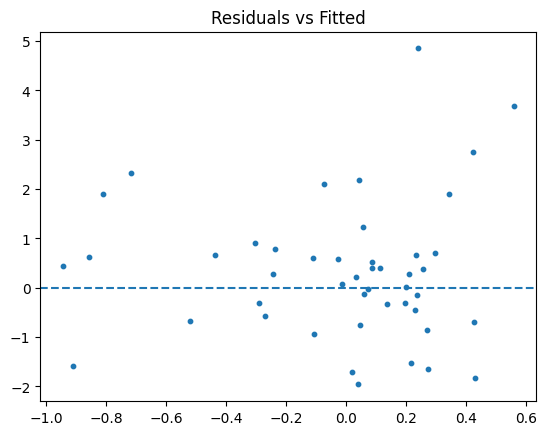

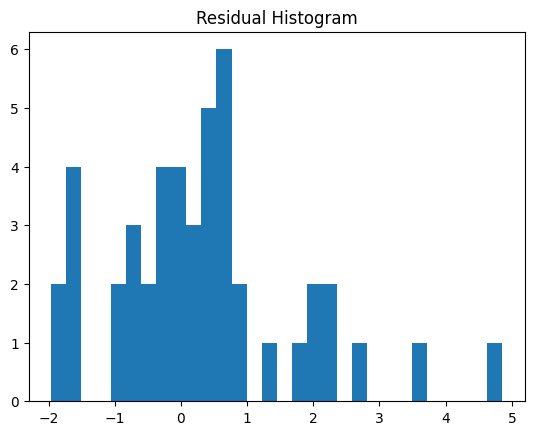

In [7]:
# Predict next-day raw return (regression)
df_reg = df.sort_values("date").copy()
df_reg["y_next_ret"] = df_reg["ret_1d"].shift(-1)
df_reg = df_reg.dropna().reset_index(drop=True)

Xr = df_reg[FEAT_BASE]
yr = df_reg["y_next_ret"]

cut = int(len(df_reg)*0.8)
Xr_tr, Xr_te = Xr.iloc[:cut], Xr.iloc[cut:]
yr_tr, yr_te = yr.iloc[:cut], yr.iloc[cut:]

reg = Pipeline([("scaler", StandardScaler()),
                ("lr", LinearRegression())])
reg.fit(Xr_tr, yr_tr)
pred = reg.predict(Xr_te)

rmse = mean_squared_error(yr_te, pred) ** 0.5
r2   = r2_score(yr_te, pred)
print(f"Regression holdout: RMSE={rmse:.6f}  R2={r2:.3f}")

# Residual diagnostics
resid = yr_te - pred
plt.figure(); plt.scatter(pred, resid, s=10); plt.axhline(0, ls="--"); plt.title("Residuals vs Fitted"); plt.show()
plt.figure(); plt.hist(resid, bins=30); plt.title("Residual Histogram"); plt.show()


## Stage 10 — Modeling Results

### Classification (Up/Down)
- **Best model:** Logistic Regression (base)
- **Accuracy:** ~59.6% (above the 50% random baseline)
- **Precision (Up days):** 0.63 — when the model predicts "Up," it's correct about 63% of the time.
- **Recall (Up days):** 0.70 — captures ~70% of actual "Up" days.
- **F1-score:** 0.67 — balanced performance for "Up."
- **ROC AUC:** 0.53 — probability calibration is weak; the model has only marginal discriminative power.

**Interpretation:**  
The logistic model demonstrates a **small predictive edge**, particularly in recall for "Up" days. However, the overall signal remains weak, consistent with the difficulty of daily return prediction in finance. Tree-based models (Random Forest) did not perform well here, suggesting simple linear/logistic approaches are better baselines.

---

### Regression (Next-Day Return)
- **RMSE:** 1.43% — average prediction error about 1.4%.
- **R²:** 0.026 — nearly zero explanatory power.

**Interpretation:**  
The regression model fails to meaningfully predict the *magnitude* of daily returns. This highlights the challenge of forecasting noisy financial data: magnitude is much harder to predict than just direction.

---

### Takeaways
- **Classification > Regression:** Directional classification (up/down) provides a more promising baseline than regression on raw returns.
- **Feature importance:** Logistic regression coefficients provide interpretable signals (e.g., volatility or gap-related features). Coefficient signs should be checked for economic intuition.
- **Risks:**  
  - Daily returns are highly noisy and heteroscedastic.  
  - Lag-based features provide limited predictive signal.  
  - ROC AUC near 0.5 shows the model struggles to generalize.  

---

### Next Steps
- Engineer richer features: volatility clustering, momentum, interactions (gap × RSI, volume × return).
- Explore **nonlinear models** (Gradient Boosting, XGBoost) for potential incremental gains.
- Try longer horizons (weekly direction instead of daily).
- Use walk-forward validation for more realistic evaluation.
